# Full Data Scientist Analysis (2021-08-03)

In the full experiment, Jake emailed ~1600 data scientists around 2PM ET on August 3rd, 2021. There will be followup emails as described in the pre-registration.

Mostly this notebook is pre-processing and tidying the data for the R analysis.

## Loading the data from mturk

In [1]:
from ast import literal_eval
from itertools import chain
from datetime import datetime, date
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', 50)
%matplotlib inline

In [2]:
df = pd.read_csv("../raw-data/datascientists.csv")

df.head()

,hit_id,assignment_id,worker_id,variable,value
0,das-20210803-prod,b521c019-c6c7-491a-829a-0a674c950dae,4501006464537369204515107537369209026231080192024,experiment,PAPER_REVIEW_PILOT2
1,das-20210803-prod,b521c019-c6c7-491a-829a-0a674c950dae,4501006464537369204515107537369209026231080192024,stage,INITIAL_PAGE_LOAD
2,das-20210803-prod,b521c019-c6c7-491a-829a-0a674c950dae,4501006464537369204515107537369209026231080192024,condition,SE_POINTS_NO_FEEDBACK
3,das-20210803-prod,b521c019-c6c7-491a-829a-0a674c950dae,4501006464537369204515107537369209026231080192024,currentTime,1628020207572
4,das-20210803-prod,b521c019-c6c7-491a-829a-0a674c950dae,4501006464537369204515107537369209026231080192024,startTime,1628020207466


In [3]:
print(f"Overall, there are {df.assignment_id.nunique()} unique assignmentIds")

Overall, there are 390 unique assignmentIds


In [4]:
df.assignment_id.value_counts().value_counts()

187    140
22      77
11      52
47      43
34      40
62      14
80       9
152      8
98       3
36       1
116      1
134      1
169      1
Name: assignment_id, dtype: int64

# Analysis of Part I

Since we have more data for Part I of the experiment, let's look at that first.

In [5]:
stage_markers = df[df.variable == 'experiment'].index

In [6]:
df_stages = []

for stage_start, stage_end in zip(stage_markers, np.concatenate([stage_markers[1:], [len(df)]])):
    df_stage = df.iloc[stage_start:stage_end]
    df_stage_pivoted = df_stage.pivot(index='assignment_id', columns='variable', values='value')
    
    df_stages.append(df_stage_pivoted)

In [7]:
def literal_eval_if_present(val):
    if pd.isnull(val):
        return val
    
    return literal_eval(val)


def get_if_present(col, val):
    if pd.isnull(val):
        return val
    
    return val[col]


def in_get_if_present(col, inner, val):
    gotten = get_if_present(col, val)
    
    try:
        return inner in gotten
    except TypeError:
        return gotten
    

def int_if_present(val):
    if pd.isnull(val):
        return val
    
    return int(val)

df_by_stage = pd.concat(df_stages)
df_by_stage['paperA_editorialResponse'] = df_by_stage['paperA_editorialResponse'].apply(literal_eval_if_present)
df_by_stage['scenario'] = df_by_stage['scenario'].apply(literal_eval_if_present)
df_by_stage['background'] = df_by_stage['background'].apply(literal_eval_if_present)
df_by_stage['guess'] = df_by_stage['guess'].apply(int_if_present)
df_by_stage['currentTime'] = df_by_stage['currentTime'].apply(int_if_present)
df_by_stage['startTime'] = df_by_stage['startTime'].apply(int_if_present)

editorialQs = ['q_appeal', 'q_sample_size', 'q_overall']
scenarioVars = ['mu1', 'mu2', 'variance1', 'variance2', 'n1', 'n2', 'probOfSuperiority']
statsVars = ['rctComfort', 'currentlyDoingResearch', 'yearsExperience']
past_activities = ['read_rct', 'published', 'conducted_rct', 'took_course', 'analyzed_data', 'used_stats_software']

for q in editorialQs:
    df_by_stage[q] = df_by_stage.paperA_editorialResponse.apply(lambda x: get_if_present(q, x))

for v in scenarioVars:
    df_by_stage[v] = df_by_stage.scenario.apply(lambda x: get_if_present(v, x))

for v in statsVars:
    df_by_stage[v] = df_by_stage.background.apply(lambda x: get_if_present(v, x))

df_by_stage['has_phd'] = df_by_stage['background'].apply(lambda x: in_get_if_present('statsTraining', 'phd', x))
for var in past_activities:
    df_by_stage[f'has_{var}'] = df_by_stage['background'].apply(lambda x: in_get_if_present('allPastActivities', var, x))

df_by_stage['has_any_stats_training'] = df_by_stage.background.str.get('statsTraining').str.len()
df_by_stage.head()

variable,assignmentId,condition,currentTime,experiment,hitId,id,stage,startTime,study_id,turkSubmitTo,workerId,paperA_editorialResponse,paperA_superiorityEstimate,paperA_whatYouSaw,paperA_whatYouSaw2,guess,scenario,trial,background,feedback,q_appeal,q_sample_size,q_overall,mu1,mu2,variance1,variance2,n1,n2,probOfSuperiority,rctComfort,currentlyDoingResearch,yearsExperience,has_phd,has_read_rct,has_published,has_conducted_rct,has_took_course,has_analyzed_data,has_used_stats_software,has_any_stats_training
assignment_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
b521c019-c6c7-491a-829a-0a674c950dae,b521c019-c6c7-491a-829a-0a674c950dae,SE_POINTS_NO_FEEDBACK,1628020207572,PAPER_REVIEW_PILOT2,das-20210803-prod,bed5a0c9-523e-47ce-948a-66e9a59da3d4,INITIAL_PAGE_LOAD,1628020207466,paper-review-pilot-2,None,4501006464537369204515107537369209026231080192024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5d1c7fc6-4ad7-42c4-ad62-c5c86571bc3d,5d1c7fc6-4ad7-42c4-ad62-c5c86571bc3d,SE_NO_FEEDBACK,1628020263440,PAPER_REVIEW_PILOT2,das-20210803-prod,2a811baa-3818-4821-870a-fa7d543bb0cd,INITIAL_PAGE_LOAD,1628020263398,paper-review-pilot-2,None,35010157605115141260511511080192024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5d1c7fc6-4ad7-42c4-ad62-c5c86571bc3d,5d1c7fc6-4ad7-42c4-ad62-c5c86571bc3d,SE_NO_FEEDBACK,1628020266587,PAPER_REVIEW_PILOT2,das-20210803-prod,dabfe02b-e510-44bb-aeec-0176916f6091,PAPER_A_PREFACE,1628020263398,paper-review-pilot-2,None,35010157605115141260511511080192024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
d8f2bf59-fa5c-41c8-bf31-0ec9b35c2a9c,d8f2bf59-fa5c-41c8-bf31-0ec9b35c2a9c,SE_NO_FEEDBACK,1628020485480,PAPER_REVIEW_PILOT2,das-20210803-prod,1d6690e8-59cd-4f95-9ebb-0c14e121d8b1,INITIAL_PAGE_LOAD,1628020485418,paper-review-pilot-2,None,4501006464537369104472124537369108647031080162024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
d8f2bf59-fa5c-41c8-bf31-0ec9b35c2a9c,d8f2bf59-fa5c-41c8-bf31-0ec9b35c2a9c,SE_NO_FEEDBACK,1628020498137,PAPER_REVIEW_PILOT2,das-20210803-prod,b2c11eff-0226-45dc-8080-534f6b3ebbc1,PAPER_A_PREFACE,1628020485418,paper-review-pilot-2,None,4501006464537369104472124537369108647031080162024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# Filter data scientists who replied after Friday August 13th, 2021

print("Before filtering on date: ", len(df_by_stage))
df_by_stage = df_by_stage[(df_by_stage['startTime'] / 1000).apply(lambda x: datetime.fromtimestamp(x).date()) <= date(2021, 8, 13)]
print("After removing responses after August 13th, 2021: ", len(df_by_stage))

Before filtering on date:  2434
After removing responses after August 13th, 2021:  2397


In [9]:
df_trials = df_by_stage[~df_by_stage.trial.isnull()]

# only keep people who finished all 5 trials
df_trials = df_trials[
    df_trials.groupby('assignmentId').trial.transform('count') == 5
]

df_trials['psup'] = (df_trials.probOfSuperiority*100).astype(int)
df_trials['signed_error'] = df_trials.guess - df_trials.psup
df_trials['unsigned_error'] = np.abs(df_trials.guess - df_trials.psup)

# Feedback

In [10]:
df_by_stage[df_by_stage.stage == 'FEEDBACK'].feedback.dropna().values

array(["There's an obvious confusion between 1) The average effect that is reported, and the likelihood of an individual exhibiting the outcome from one cohort compared to the other.  I presume that's what at issue here. Just for interpretation, the likelihood ratio of a treatment versus control individual is more intuitive than guessing probability in your examples. The likelihoods tended to be small (just above 1); my intuition in how those translate into probabilities is not obvious;  say 50% probability is roughly a likelihood ration of 1:1. ",
       'It was unclear to me whether you were hoping I’d hazard a guess or find my calculator and consult a CDF table: I tried the latter (but my math might be bad)',
       "I think the first graph was incorrect. The boxplot lines should have overlapped (mean of 6.8 + s.d. of 0.5 should have spanned 7.3 to 6.3 which included the mean of the other group). Though I'm not sure we were given enough information to actually answer the question. T

In [11]:
df_by_stage[df_by_stage.stage == 'FEEDBACK'].dropna(subset=['feedback'])[['assignmentId', 'workerId', 'condition', 'feedback']].to_csv("../tidy-data/datascientists-tidy-feedback.tsv", sep="\t")

### Timing data

We recorded timestamps of the start and end in milliseconds since the Epoch. Mostly we are curious if they are completing the task too quickly (<3 minutes?)

In [12]:
df_by_stage['elapsed'] = df_by_stage.currentTime - df_by_stage.startTime

In [13]:
end_of_part1 = df_by_stage[df_by_stage.stage == 'PSUP_GAME_PREFACE'].currentTime - df_by_stage[df_by_stage.stage == 'PSUP_GAME_PREFACE'].startTime
feedback_stage = df_by_stage[df_by_stage.stage == 'FEEDBACK'].currentTime - df_by_stage[df_by_stage.stage == 'FEEDBACK'].startTime

(0.0, 100.0)

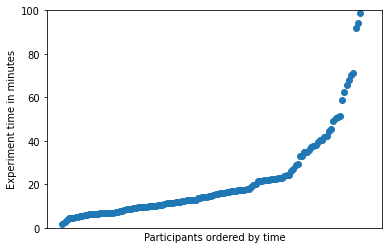

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.scatter(
    range(len(feedback_stage)),
    (feedback_stage / 1000 / 60).sort_values(),
)

ax.set_xlabel("Participants ordered by time")
ax.set_xticks([])
ax.set_ylabel("Experiment time in minutes")
ax.set_ylim([0, 100])

# Cleanup before outputting

We want the data to be tidy. Thus we will end up with four dataframes:

* first is editorial
* second is psup game 
* third is time stamps, with all stages (and maybe ts_trial_1, ts_trial_2, etc. for psup game?)
* fourth is background survey

In [15]:
df_last_stage_per_assignment = df_by_stage.sort_values(by=['assignmentId', 'elapsed']).groupby('assignment_id').last()

In [16]:
# New rule is that editorial data must have Part I of experiment completed
# (ie, finished the PAPER_A_UNDERSTANDING stage)

df_tidy_editorial = df_by_stage[df_by_stage.stage == 'PAPER_A_UNDERSTANDING'].drop(['currentTime', 'startTime', 'turkSubmitTo', 'guess', 'scenario', 'trial', 'background', 'feedback', 'mu1', 'mu2', 'variance1', 'variance2', 'n1', 'n2', 'probOfSuperiority', 'rctComfort', 'currentlyDoingResearch', 'yearsExperience', 'has_phd', *[f'has_{var}' for var in past_activities]], axis=1)
df_tidy_editorial.to_csv("../tidy-data/datascientists-tidy-editorial.csv", index=False)

In [17]:
# How much data will we lose if we require people finish Part I completely?

print("Number of people who made it to various stages:")
print(df_by_stage.drop_duplicates(['assignmentId', 'stage']).stage.value_counts())

Number of people who made it to various stages:
INITIAL_PAGE_LOAD        377
PAPER_A_PREFACE          333
PAPER_A_REVIEW           259
PAPER_A_PSUP             219
PAPER_A_UNDERSTANDING    175
PSUP_GAME                161
BACKGROUND_SURVEY        139
FEEDBACK                 138
Name: stage, dtype: int64


In [18]:
df_by_stage.drop_duplicates(['assignmentId', 'stage']).stage.value_counts().reset_index().rename(columns={'index': 'stage', 'stage': 'finishers'}).to_csv("./results/datascientists_finishers_by_stage.csv", index=False)

In [19]:
common_vars = ['assignmentId', 'condition', 'experiment', 'hitId', 'id', 'study_id', 'workerId', ]

In [20]:
# Writing out psup game trials

df_trials[common_vars + ['guess', 'trial', 'mu1', 'mu2', 'variance1', 'variance2', 'n1', 'n2', 'psup', 'signed_error', 'unsigned_error']].to_csv("../tidy-data/datascientists-tidy-psup-game.csv", index=False)

In [21]:
# Writing out background data

df_background_data = df_last_stage_per_assignment[common_vars + ['rctComfort', 'currentlyDoingResearch', 'yearsExperience', 'has_phd', 'has_any_stats_training'] + [f'has_{var}' for var in past_activities]]
df_background_data.to_csv("../tidy-data/datascientists-tidy-background.csv", index=False)

In [22]:
# Writing out timing data

df_by_stage['stage_trial'] = df_by_stage.stage + '-' + df_by_stage.trial.fillna('1')
df_by_stage[common_vars + ['stage', 'trial', 'stage_trial', 'elapsed']].to_csv("../tidy-data/datascientists-tidy-elapsed.csv", index=False)